In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loss_grad(x, diag_A, noise_amplitude=0):
    return diag_A * (x + np.random.normal(scale=noise_amplitude, size=x.size))

In [3]:
class Momentum():
    def __init__(
        self, x_0, alpha, beta, diag_A=np.array([1.]), z_0=0, 
        gradient_noise_amplitude=0.
    ):
        self.diag_A = diag_A
        self.x = x_0
        self.z = z_0
        self.alpha = alpha
        self.beta = beta
        self.gradient_noise_amplitude = gradient_noise_amplitude
    
    def step(self):
        z_new = self.beta * self.z + loss_grad(self.x, self.diag_A, self.gradient_noise_amplitude)
        x_new = self.x - self.alpha * z_new
        self.x = x_new
        self.z = z_new
        return x_new, z_new

In [4]:
class MyOptimizer():
    def __init__(
        self, x_0, alpha_0, diag_A=np.array([1.]), max_alpha_gain=10., tol=1e-8, 
        gradient_noise_amplitude=0.
    ):
        self.diag_A = diag_A
        self.x = x_0
        self.alpha = alpha_0
        self.max_alpha_gain = max_alpha_gain
        self.tol = tol
        self.gradient_noise_amplitude = gradient_noise_amplitude
    
    def step(self):
        grad = loss_grad(self.x, self.diag_A, self.gradient_noise_amplitude)
        x_new = self.x - self.alpha * grad
        grad_new = loss_grad(x_new, self.diag_A, self.gradient_noise_amplitude)
        alpha_new = self.alpha / np.clip(
            1 - np.sum(grad * grad_new) / (np.sum(grad ** 2) + self.tol), 1. / self.max_alpha_gain, None
        ) 
        self.x = x_new
        self.alpha = alpha_new
        return x_new, alpha_new

## Toy quadratic

In [435]:
max_steps = 2000
x_0 = np.array([10., 10., 10.])
diag_A = np.array([100., 1., 0.01])
gradient_noise_amplitude = 1e-5

opts = {
    'my': MyOptimizer(
        x_0=x_0, alpha_0=1, diag_A=diag_A, max_alpha_gain=16., gradient_noise_amplitude=gradient_noise_amplitude
    ),
    'momentum': Momentum(
        x_0=x_0, diag_A=diag_A,
        alpha=4. / (np.sqrt(np.max(diag_A)) + np.sqrt(np.min(diag_A))) ** 2,
        beta=(
            (np.sqrt(np.max(diag_A)) - np.sqrt(np.min(diag_A))) / (np.sqrt(np.max(diag_A)) + np.sqrt(np.min(diag_A)))
        ) ** 2,
        gradient_noise_amplitude=gradient_noise_amplitude
    )
}
xs, alphas = {}, {}
for name, opt in opts.items():
    xs[name], alphas[name] = [], []
    for _ in range(max_steps):
        x, alpha = opt.step()
        xs[name].append(x)
        alphas[name].append(alpha)

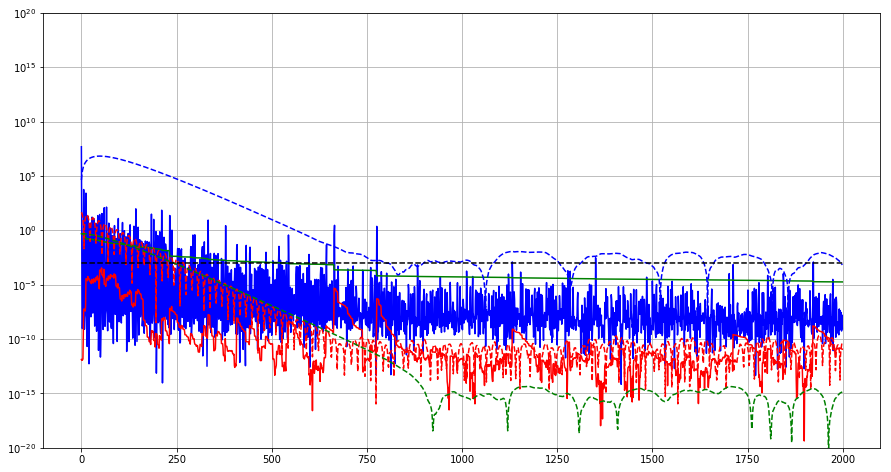

In [436]:
colors = ['b', 'r', 'g']
styles = ['', '--']

plt.figure(figsize=(15, 8))
for i, name in enumerate(opts.keys()):
    for j in range(len(diag_A)):
        plt.plot(
            np.clip(0.5 * np.array(xs[name])[:, j] ** 2 * diag_A[j], a_min=1e-100, a_max=None), colors[j] + styles[i]
        )
plt.plot([1e-3] * max_steps, 'k--')
plt.yscale('log')
plt.ylim(1e-20, 1e20)
plt.grid(True)

In [387]:
np.array(xs['my'])[:, 2]

array([ 9.89999993,  9.89900983,  9.89801993,  9.89702997,  9.88713136,
        9.7882444 ,  9.4380779 ,  9.43709919,  9.43615548,  9.43521149,
        9.42577248,  9.33147687,  9.13253548,  9.13160244,  9.13068927,
        9.12977549,  9.12063864,  9.02936154,  8.99908974,  8.99818688,
        8.99728708,  8.99612459,  8.98450119,  8.8684171 ,  8.83956511,
        8.8386795 ,  8.83779561,  8.83643453,  8.82282587,  8.68694855,
        7.34910064,  7.34285983,  7.34212554,  7.34139133,  7.33404992,
        7.26070945,  7.24605391,  7.24532794,  7.24460339,  7.24278215,
        7.22457435,  7.0492849 ,  7.04827712,  7.04757228,  7.04686751,
        7.03982049,  6.9694208 ,  6.96442615,  6.96372929,  6.96303295,
        6.95607026,  6.88651305,  6.793304  ,  6.79261542,  6.79193617,
        6.79125314,  6.78442359,  6.71619685,  6.70633885,  6.70566727,
        6.70499666,  6.70150117,  6.6665645 ,  6.31901952,  6.31211094,
        6.31147972,  6.31084857,  6.30453765,  6.24149156,  6.20

## MNIST

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [3]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [4]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 32)
        self.linear2 = nn.Linear(32, 10)

    def forward(self, inputs):
        x = inputs.view(-1, 28 * 28)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)


In [78]:
class Smoker():
    def __init__(self, param_iter, init_lr, max_lr_gain=2, max_lr_decay=2, tol=1e-8,
                 separate_lrs=False, conjugate_grads=False):
        self.max_lr_gain = max_lr_gain
        self.max_lr_decay = max_lr_decay
        self.tol = tol
        self.param_iter = list(param_iter)
        self.separate_lrs = separate_lrs
        self.conjugate_grads = conjugate_grads
        if separate_lrs:
            self.lrs = [np.float64(init_lr)] * len(self.param_iter)
            self.old_grads = [cuda_wrapper(torch.zeros_like(param.data)) for param in self.param_iter]
        else:
            self.lrs = [np.float64(init_lr)]
            self.old_flat_grad = torch.cat(
                [cuda_wrapper(torch.zeros_like(param.data)).view(-1) for param in self.param_iter]
            )
    
    def step(self):
        if self.separate_lrs:
            for i, param in enumerate(self.param_iter):
                param.data = param.data - float(self.lrs[i]) * param.grad.data
                lr_decay = 1 - torch.sum(
                    param.grad.data * self.old_grads[i]
                ) / (torch.sum(self.old_grads[i] ** 2) + self.tol)
                if lr_decay < 0.:
                    lr_decay = 1.
                self.lrs[i] /= np.clip(lr_decay, 1. / self.max_lr_gain, self.max_lr_decay)
                self.old_grads[i].copy_(param.grad.data)
        else:
            for i, param in enumerate(self.param_iter):
                param.data = param.data - float(self.lrs[0]) * param.grad.data
            flat_grad = torch.cat([param.grad.data.view(-1) for param in model.parameters()])
            if self.conjugate_grads:
                beta = 
            lr_decay = 1 - torch.sum(flat_grad * self.old_flat_grad) / (torch.sum(self.old_flat_grad ** 2) + self.tol)
            if lr_decay < 0.:
                lr_decay = 1.
            self.lrs[0] /= np.clip(lr_decay, 1. / self.max_lr_gain, self.max_lr_decay)
            self.old_flat_grad.copy_(flat_grad)


In [ ]:
opt_names = ['smoker', 'momentum', 'adam']

max_epochs = 50

losses = {}
lrs = []

for opt_name in opt_names:
#for opt_name in ['smoker']:
    print('{}:'.format(opt_name))
    torch.random.manual_seed(123)
    model = cuda_wrapper(Model())
    #print(len(list(model.parameters())))
    if opt_name == 'smoker':
        opt = Smoker(model.parameters(), init_lr=1e-3, max_lr_gain=1.4, max_lr_decay=1.4)
    elif opt_name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=1e-3)
    elif opt_name == 'momentum':
        opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    elif opt_name == 'adam':
        opt = optim.Adam(model.parameters())
    losses[opt_name] = []
    for epoch in range(max_epochs):
        cum_loss = 0.
        step_count = 0
        for X, y in train_loader:
            model.zero_grad()
            X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
            prob = model(X)
            loss = F.nll_loss(prob, y)
            loss.backward()
            opt.step()
            losses[opt_name].append(loss.data[0])
            if opt_name == 'smoker':
                lrs.append(opt.lrs[0])
            cum_loss += loss.data[0]
            step_count += 1
        print('Epoch {}; loss = {:.4f}'.format(epoch+1, cum_loss / step_count))
    print()

smoker:
Epoch 1; loss = 0.3768
Epoch 2; loss = 0.2689
Epoch 3; loss = 0.2413
Epoch 4; loss = 0.2179
Epoch 5; loss = 0.1909
Epoch 6; loss = 0.1677
Epoch 7; loss = 0.1609
Epoch 8; loss = 0.1503
Epoch 9; loss = 0.1359
Epoch 10; loss = 0.1304
Epoch 11; loss = 0.1272
Epoch 12; loss = 0.1217
Epoch 13; loss = 0.1191
Epoch 14; loss = 0.1191
Epoch 15; loss = 0.1085
Epoch 16; loss = 0.1003
Epoch 17; loss = 0.1013
Epoch 18; loss = 0.1123
Epoch 19; loss = 0.0940
Epoch 20; loss = 0.0843
Epoch 21; loss = 0.0860
Epoch 22; loss = 0.0865
Epoch 23; loss = 0.0863
Epoch 24; loss = 0.0892
Epoch 25; loss = 0.0706
Epoch 26; loss = 0.0667
Epoch 27; loss = 0.0664
Epoch 28; loss = 0.0758
Epoch 29; loss = 0.0696
Epoch 30; loss = 0.0626
Epoch 31; loss = 0.0619
Epoch 32; loss = 0.0616
Epoch 33; loss = 0.0615
Epoch 34; loss = 0.0615
Epoch 35; loss = 0.0615
Epoch 36; loss = 0.0631
Epoch 37; loss = 0.0678
Epoch 38; loss = 0.0616
Epoch 39; loss = 0.0612
Epoch 40; loss = 0.0612
Epoch 41; loss = 0.0612
Epoch 42; loss = 

In [114]:
def running_average(a, alpha=0.99):
    #a = np.array(a)
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i-1] + (1 - alpha) * a[i]
    return av

(0, 0.5)

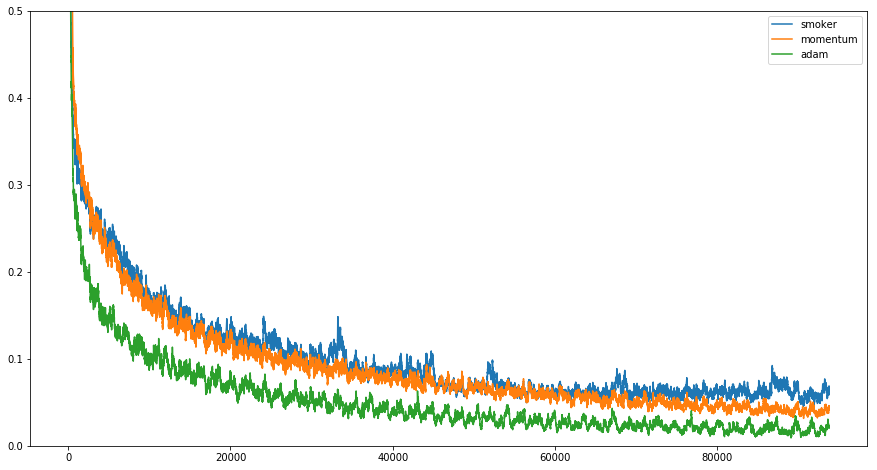

In [120]:
plt.figure(figsize=(15,8))
for opt_name in opt_names:
    plt.plot(running_average(losses[opt_name], alpha=0.99))
plt.legend(opt_names)
plt.ylim(0, 0.5)

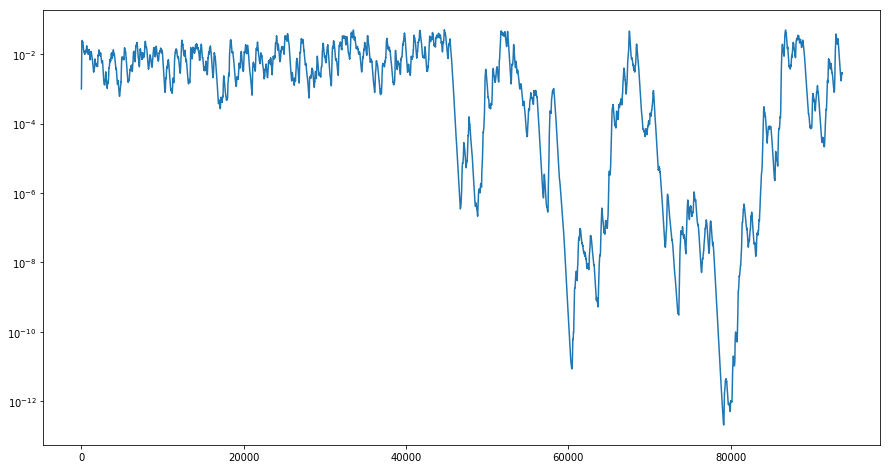

In [121]:
plt.figure(figsize=(15,8))
plt.plot(running_average(lrs))
plt.yscale('log')
#plt.ylim(ymin=1e-10)